In [6]:
# --- CELL 1: IMPORTS & SETUP ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pmdarima as pm
from sklearn.metrics import mean_squared_error, mean_absolute_error
import joblib
import sys
import os

sys.path.append(os.path.abspath(os.path.join('..')))
from src.config import PROCESSED_DATA_PATH, MODEL_PATH

In [7]:
# --- CELL 2: LOAD & SPLIT ---
print(f"Loading data from: {PROCESSED_DATA_PATH}")
df = pd.read_csv(PROCESSED_DATA_PATH, parse_dates=['Date'], index_col='Date')
df.sort_index(inplace=True)

# Split 90/10
train_size = int(len(df) * 0.9)
train_data = df['Close'][:train_size]
test_data = df['Close'][train_size:]
print(f"Train Samples: {len(train_data)}, Test Samples: {len(test_data)}")

Loading data from: C:\VS Code\amdox-data-analytics\data\processed\processed_stock_data.csv
Train Samples: 2717, Test Samples: 302


In [8]:
# --- CELL 3: TRAINING (Auto-ARIMA) ---
print("Training Model... (This may take time)")
model = pm.auto_arima(train_data,
                      m=7,              # Weekly Seasonality
                      d=1,              # Differencing
                      seasonal=True,
                      stepwise=True,
                      suppress_warnings=True,
                      error_action='ignore')

print(f"Best Model: {model.order}")
print(model.summary())

Training Model... (This may take time)
Best Model: (0, 1, 0)
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 2717
Model:               SARIMAX(0, 1, 0)   Log Likelihood               -2530.251
Date:                Thu, 29 Jan 2026   AIC                           5062.502
Time:                        18:19:23   BIC                           5068.408
Sample:                             0   HQIC                          5064.637
                               - 2717                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         0.3773      0.003    146.177      0.000       0.372       0.382
Ljung-Box (L1) (Q):                   0.20   Jarque-Bera (JB):        

Forecasting...
RMSE: 16.33


c:\VS Code\amdox-data-analytics\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\VS Code\amdox-data-analytics\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


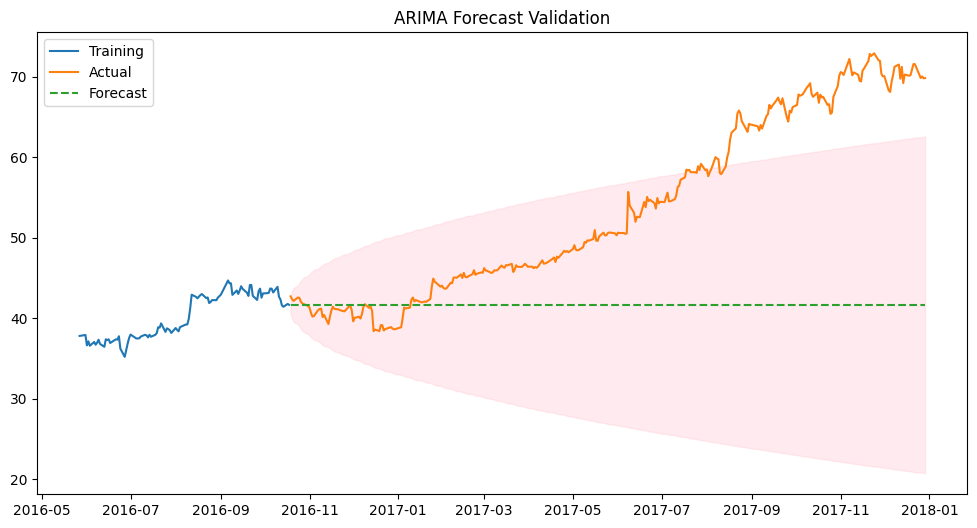

In [9]:
# --- CELL 4: FORECAST & VALIDATION ---
print("Forecasting...")
forecast, conf_int = model.predict(n_periods=len(test_data), return_conf_int=True)

# Metrics
rmse = np.sqrt(mean_squared_error(test_data, forecast))
print(f"RMSE: {rmse:.2f}")

# Plot
plt.figure(figsize=(12, 6))
plt.plot(train_data.index[-100:], train_data[-100:], label='Training')
plt.plot(test_data.index, test_data, label='Actual')
plt.plot(test_data.index, forecast, label='Forecast', linestyle='--')
plt.fill_between(test_data.index, conf_int[:, 0], conf_int[:, 1], color='pink', alpha=0.3)
plt.legend()
plt.title('ARIMA Forecast Validation')
plt.show()

In [10]:
# --- CELL 5: SAVE & EXPORT ---
# Save Model
joblib.dump(model, MODEL_PATH)

# Export for Power BI
export_df = pd.DataFrame({
    'Date': test_data.index,
    'Actual_Price': test_data.values,
    'Predicted_Price': forecast.values,
    'Lower_Conf': conf_int[:, 0],
    'Upper_Conf': conf_int[:, 1]
})
export_df.to_csv("../data/processed/forecast_results.csv", index=False)
print("Results exported for Power BI.")

Results exported for Power BI.
